## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

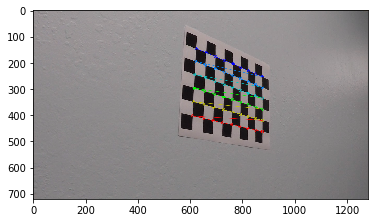

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

## Test undistort on flat chessboard

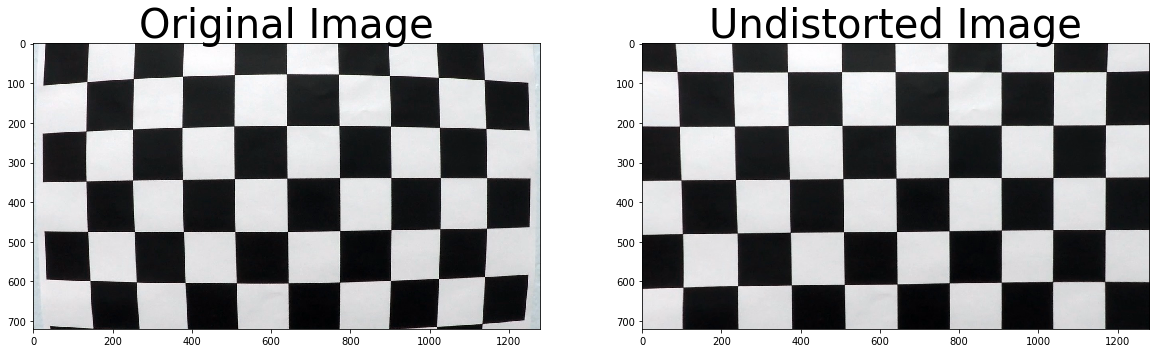

In [2]:
img = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=40)
f.savefig('output_images/chessboard_undistort.png')

## Test undistort on sample highway lane image

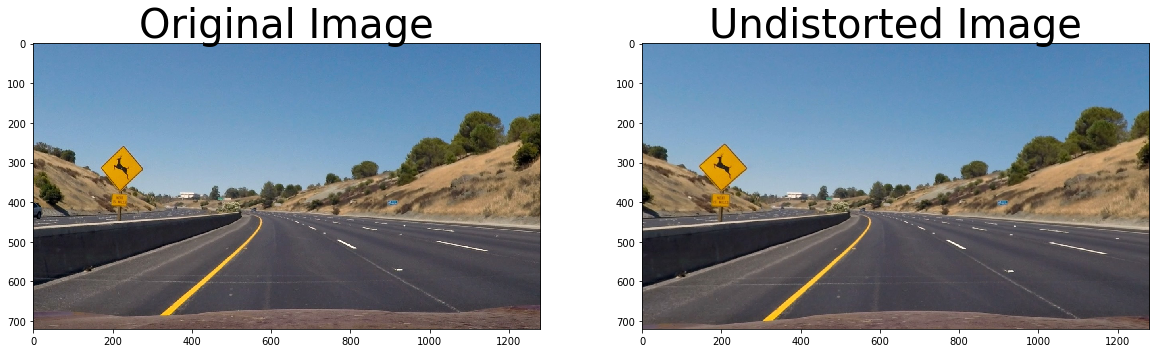

In [3]:
test_image = plt.imread('test_images/test2.jpg')
undistorted_image = cv2.undistort(test_image, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=40)
f.savefig('output_images/testimage_undistort.png')

## Save camera calibration info to file

In [4]:
import pickle

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration_result.p", "wb" ) )

## Helper functions for all parts of advanced lane finder pipeline

In [5]:
def treshold_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    #color_binary = sxbinary + s_binary
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def warp_image(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped_img, M, Minv

def search_and_fit_lane_lines(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    lane_line_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    lane_line_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    lane_line_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return lane_line_img, left_fit, right_fit, leftx, lefty, rightx, righty

def draw_lane_canvas(image,left_fit,right_fit):
    lane_canvas_image = np.zeros_like(image).astype(np.uint8)

    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    points_left     = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    points_right    = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    points_combined = np.hstack((points_left, points_right))

    cv2.fillPoly(lane_canvas_image, np.int_([points_combined]), (0,255, 0))

    return lane_canvas_image

def find_curvatures(left_fit, right_fit, leftx, lefty, rightx, righty):
    y_eval = 720#np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 35/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr  = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    #left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    #right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

def find_offset_center(image_center, left_fit, right_fit):
    left_fitx  = left_fit[0]*image_center**2 + left_fit[1]*image_center + left_fit[2]
    right_fitx = right_fit[0]*image_center**2 + right_fit[1]*image_center + right_fit[2]    
    offset_center = (1.5 * left_fitx - right_fitx) / 2
    offset_center = offset_center / 12800 * 3.7
    return offset_center

def add_curvature_info_to_image(image, curvature, vehicle_position):
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, 'Radius of Curvature = %d(m)' % curvature, (50, 50), font, 1, (255, 255, 255), 2)
    left_or_right = "left" if vehicle_position < 0 else "right"
    cv2.putText(image, 'Vehicle is %.2fm %s of center' % (np.abs(vehicle_position), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)

## Test advanced lane finder step-by-by-step before making pipeline

### Step 1: Color & gradient treshold image

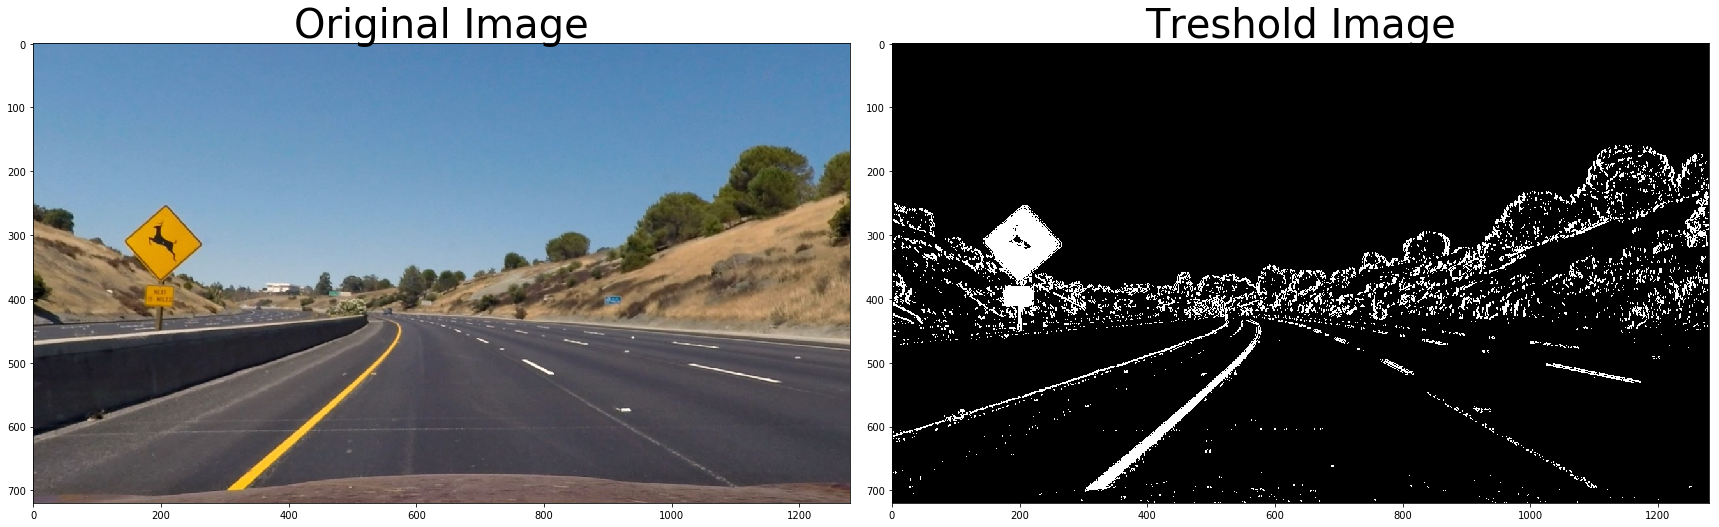

In [6]:
tresh_image = treshold_image(undistorted_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted_image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(tresh_image, cmap='gray')
ax2.set_title('Treshold Image', fontsize=40)
f.savefig('output_images/testimage_treshold.png')

### Step 2: Apply region of interest

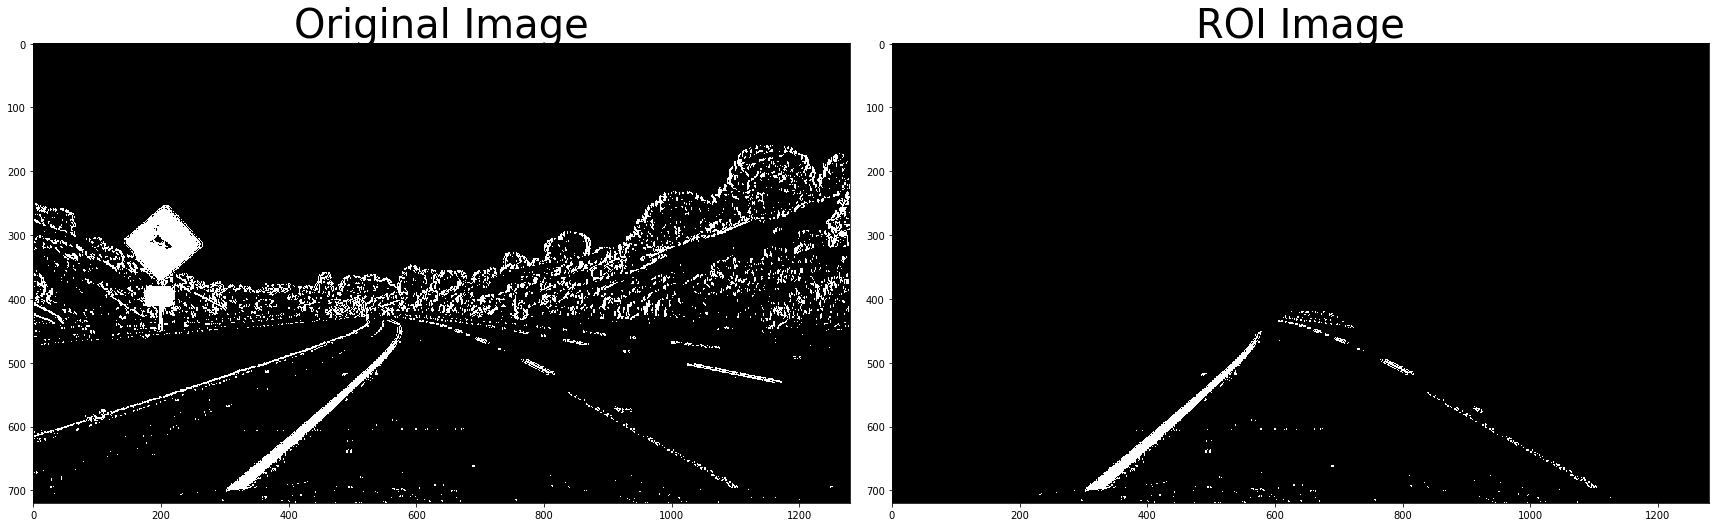

In [7]:
vertices = [[[620, 420],[685, 420],[1150,720],[200,720]]]
roi_image = region_of_interest(tresh_image, np.array(vertices, dtype=np.int32))


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(tresh_image, cmap='gray')
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(roi_image, cmap='gray')
ax2.set_title('ROI Image', fontsize=40)
f.savefig('output_images/testimage_roi.png')

### Step 3: Warp to get bird's eye view of lanes

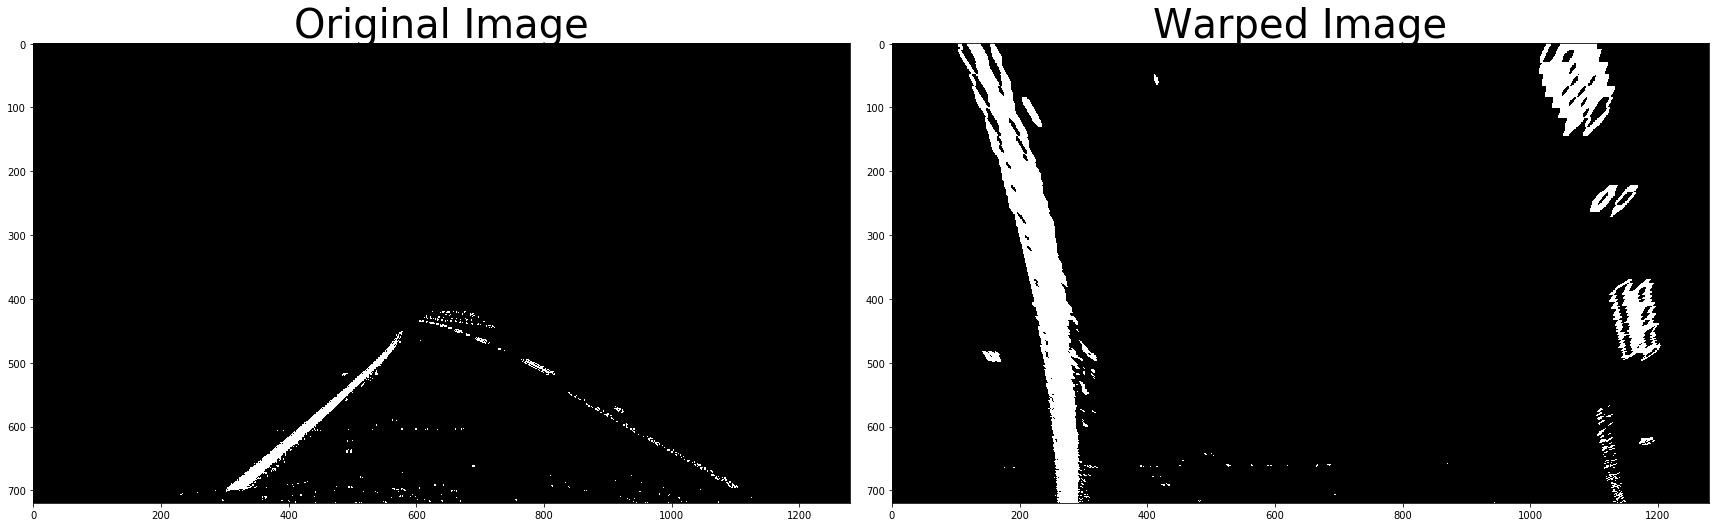

In [8]:
img_size = (roi_image.shape[1], roi_image.shape[0])
src = np.float32(
    [[264, 686],
     [580, 462],
     [700, 462],
     [1034, 686]])

dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

binary_warped = cv2.warpPerspective(roi_image, M, img_size, flags=cv2.INTER_LINEAR)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(roi_image, cmap='gray')
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped Image', fontsize=40)
f.savefig('output_images/testimage_warped.png')

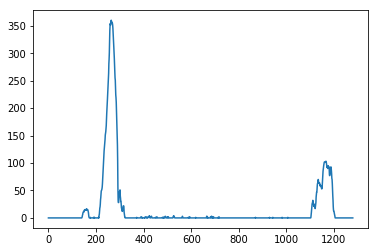

In [9]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.savefig('output_images/histogram.png')

### Step 4: Plot fitted poly lines on lanes

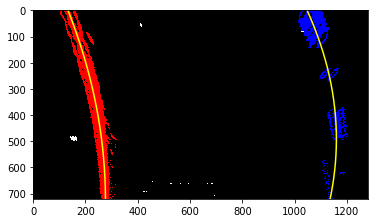

In [10]:
line_fitted_image, left_fit, right_fit, leftx, lefty, rightx, righty = search_and_fit_lane_lines(binary_warped)
#out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

ploty = np.linspace(0, line_fitted_image.shape[0]-1, line_fitted_image.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.imshow(line_fitted_image)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/testimage_linefitted.png')

### Step 5: Draw lane canvas

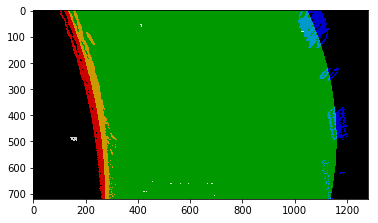

In [11]:
lane_canvas_image = draw_lane_canvas(line_fitted_image,left_fit,right_fit)
combined_image = cv2.addWeighted(line_fitted_image, 0.8, lane_canvas_image, 0.6, 0)
plt.imshow(combined_image)
plt.savefig('output_images/testimage_canvasandlinefitted.png')

### Step 6: Unwarp and combine lane drawing with original image

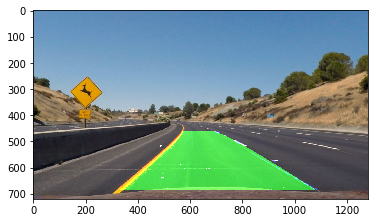

In [12]:
#Step 8: Unwarp the lane line & canvas image
lane_lines = cv2.warpPerspective(combined_image, Minv, (combined_image.shape[1], combined_image.shape[0]), 
                                     flags=cv2.INTER_LINEAR)

#Step 9: Combine lane drawing image with original undistorted image
pipeline_img = cv2.add(lane_lines, undistorted_image)

plt.imshow(pipeline_img)
plt.savefig('output_images/testimage_unwarped.png')

### Step 7: Calculate curvature, vehicle offset to center, and project onto image

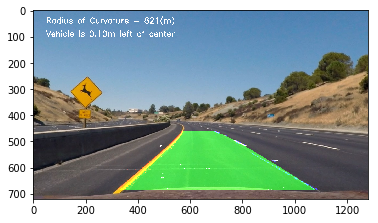

In [13]:
curv_left, curv_right = find_curvatures(left_fit,right_fit, leftx, lefty, rightx, righty)
vehicle_pos = find_offset_center(719, left_fit, right_fit)

add_curvature_info_to_image(pipeline_img, curv_left, vehicle_pos)
plt.imshow(pipeline_img)
plt.savefig('output_images/testimage_curvature.png')

## Video image processing pipeline

In [14]:
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]
    
def image_pipeline(input_image, filepath=False, debug=False):
    #Step 1: Undistort image
    undistorted_image = cv2.undistort(input_image, mtx, dist, None, mtx)
        
    #Step 2: Color & gradient treshold image
    tresh_image = treshold_image(undistorted_image)
    
    #Step 3: Apply region of interest
    vertices = [[[620, 420],[685, 420],[1150,720],[200,720]]]
    
    roi_image = region_of_interest(tresh_image, np.array(vertices, dtype=np.int32))
    
    #Step 4: Warp image to get bird's eye view
    src = np.float32(
        [[264, 686],
         [580, 462],
         [700, 462],
         [1034, 686]])

    dst = np.float32(
        [[200,720],
         [200,0],
         [1080,0],
         [1080,720]])
    
    warped_image, M, Minv = warp_image(roi_image, src, dst)
    
    #Step 5: Search and fit polylines
    line_fitted_image, left_fit, right_fit, leftx, lefty, rightx, righty = search_and_fit_lane_lines(warped_image)
    
    #Step 6: Draw lane canvas
    lane_canvas_image = draw_lane_canvas(line_fitted_image,left_fit,right_fit)
    
    #Step 7: Combine the lane lines & lane canvas
    combined_image = cv2.addWeighted(lane_canvas_image, 0.5, line_fitted_image, 0.6, 0)  
    
    #Step 8a: Unwarp the lane line & canvas image
    lane_lines = cv2.warpPerspective(combined_image, Minv, (combined_image.shape[1], combined_image.shape[0]), 
                                     flags=cv2.INTER_LINEAR)

    #Step 8b: Combine lane drawing image with original undistorted image
    pipeline_img = cv2.add(lane_lines, undistorted_image)

    #Step 9: Get curvature & vehicle position relative to lane center and add info overlay to image
    curv_left, curv_right = find_curvatures(left_fit,right_fit, leftx, lefty, rightx, righty)
    vehicle_pos = find_offset_center(719, left_fit, right_fit)

    add_curvature_info_to_image(pipeline_img, curv_left, vehicle_pos)
    
    return pipeline_img

## Test pipeline on sample image

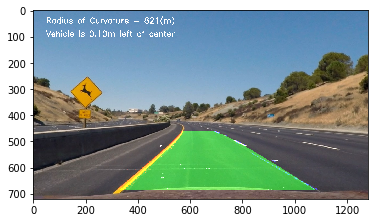

In [15]:
test_pipeline_image = plt.imread('test_images/test2.jpg')
pipe_out_image = image_pipeline(test_pipeline_image)
plt.imshow(pipe_out_image)

## Run video through image processing pipeline

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
output = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:18<00:00,  4.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 4min 20s
